In [142]:
import pandas as pd 
import numpy as np 
import seaborn as sns
"""
    REMEMBER
"""
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.graphics.regressionplots import influence_plot
from scipy.stats import zscore

df = sns.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [143]:
"""
    REMEMBER
    1. get_dummies in pd 
    2. `drop_first = True` prevents separate columns like in sex ie sex_female , sex_male only one will be present
"""
df = pd.get_dummies(df, drop_first=True)
df.head()

,total_bill,tip,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,16.99,1.01,2,True,True,False,False,True,True
1,10.34,1.66,3,False,True,False,False,True,True
2,21.01,3.50,3,False,True,False,False,True,True
3,23.68,3.31,2,False,True,False,False,True,True
4,24.59,3.61,4,True,True,False,False,True,True


<Axes: >

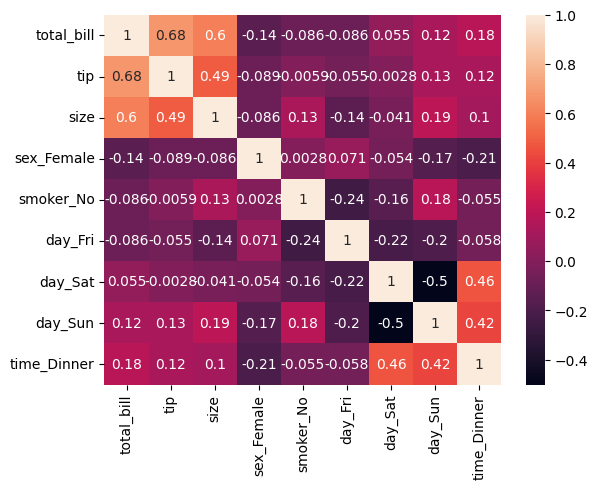

In [144]:
sns.heatmap(df.corr(),annot=True)

In [145]:
# highest correlation with total_bill
X = df['total_bill']
Y = df['tip']

""" 
    REMEMBER
    1. Adding constant data for beta0 
"""

X = sm.add_constant(X)

In [146]:
"""
    REMEMBER 
    1. Dividing data into test and train
    2. test_size=0.2 means 20% of the data will be used for testing, while 80% will be used for training.
    3. train_size=0.8 means 80% for training rest for testing
    4. random_state = 42  seed value for generating random value to select random records
"""
train_X , test_X, train_y, test_y = train_test_split(X,Y,train_size=0.8,random_state=42)

In [147]:
"""
    REMEMBER 
"""
model_OLS = sm.OLS(train_y, train_X).fit()

In [148]:
"""
    REMEMBER
"""
print("Coefficients:")
print(model_OLS.params)

Coefficients:
const         0.925236
total_bill    0.106964
dtype: float64


In [149]:
"""
    REMEMBER
    1. 0 <= r2 <= 1 higher the better
    2. An R-squared value of, say, 0.75 means that 75% of the variability in the dependent variable can be 
    explained by the model’s predictors
    3. P value < alpha ( say alpha = 0.1 ) means this variable significantly affect dependent variable 
    4. Lower the P value the better
"""
print(f"Rsqaure = {model_OLS.rsquared}")
print()
print(f"P Values: \n{model_OLS.pvalues}")

Rsqaure = 0.43095110383706525

P Values: 
const         4.010821e-06
total_bill    2.043745e-25
dtype: float64


In [150]:
"""
    REMEMBER
    
"""
pred_tip = model_OLS.predict(test_X)
resutl_df = pd.DataFrame({'pred_tip':pred_tip,'actual_tip':test_y})
resutl_df.head()

,pred_tip,actual_tip
24,3.045256,3.18
6,1.863307,2.00
153,3.551195,2.00
211,3.694526,5.16
198,2.315764,2.00


In [151]:
"""
    REMEMBER
    1. Lower Means Squre Error means better model
    
"""
print(f"Rsquare (test) = {r2_score(test_y,pred_tip)}") 
print(f"Mean Squared Error (test) = {mean_squared_error(test_y,pred_tip)}")

Rsquare (test) = 0.5449381659234672
Mean Squared Error (test) = 0.5688142529229527


In [152]:
# Determining Outliers based on z-score , cooks and levarage

In [153]:
"""
    REMEMBER
    1. z-score > 3 will be outlier as not present within 97% of data
    
"""
df['z_score'] = zscore(df['total_bill'])
mask = df['z_score'] > 3
df[mask]

,total_bill,tip,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner,z_score
59,48.27,6.73,4,False,True,False,True,False,True,3.206166
156,48.17,5.00,6,False,True,False,False,True,True,3.194910
170,50.81,10.00,3,False,False,False,True,False,True,3.492068
212,48.33,9.00,4,False,True,False,True,False,True,3.212919


Index of training data that are potential outliers: []


<Axes: xlabel='None', ylabel='cooks_d'>

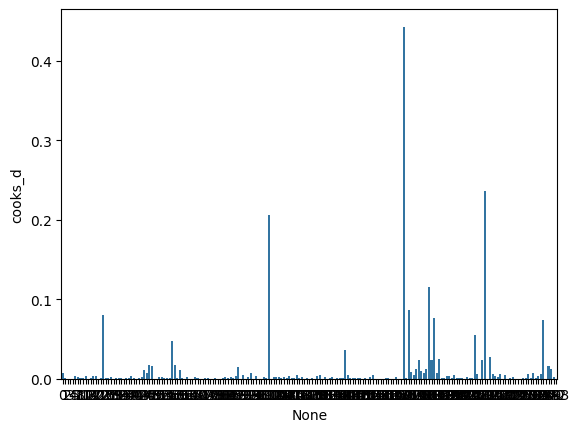

In [154]:
"""
    REMEMBER
    0. Cook’s distance measures how much the predicted value of the dependent variable changes for all the
    observations in the sample when a particular observation is excluded from the sample for the estimation
    of regression parameters.
    1. Cook's Distance > 1 means highly influential value and an outlier
    2. Cook's Distnace is calculated for training data only
    
"""
influence = model_OLS.get_influence()
cooks_d = influence.cooks_distance[0]
train_X['cooks_d']  = cooks_d
print("Index of training data that are potential outliers:",np.array(train_X[train_X['cooks_d']>1].index))
sns.barplot(x=train_X.index,y=train_X['cooks_d'])

Index of training data that are potential outliers: [ 95 170 184 182  59 212 102]


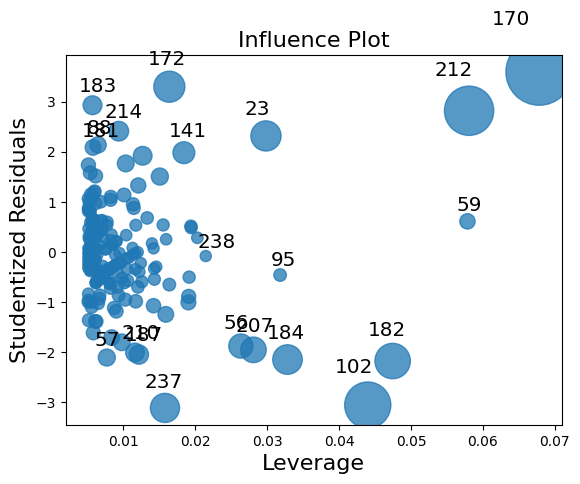

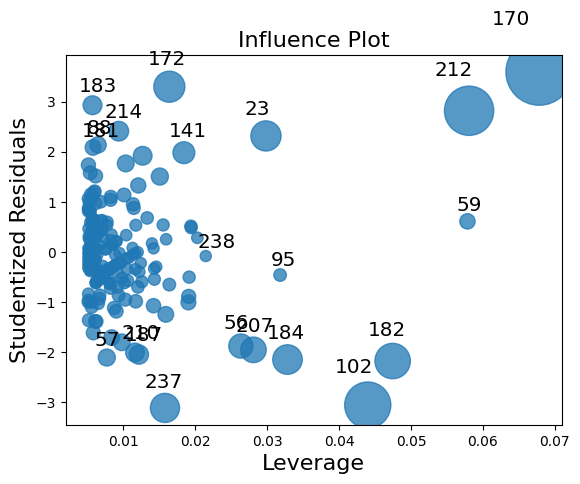

In [162]:
"""
    REMEMBER
    1. Leverage value of an observation measures the influence of that observation on the overall fit of the regression function
    2. Training Data only
    3. Leverage value of more than 3(k + 1)/n is treated as highly influential observation k -> features count , n -> sample size 
    ( train data size)
    
"""
leverage = influence.hat_matrix_diag
train_X['leverage'] = leverage
k = 1 # only total_bill used as feature
n = train_X.shape[0]
print("Index of training data that are potential outliers:",np.array(train_X[train_X['leverage']>(3*(k+1))/n].index))
influence_plot(model_OLS)